In [12]:
#必要なパッケージのインポート

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

from scipy.integrate import solve_ivp
import pandas as pd
from reservoirpy.observables import nrmse, rsquare


rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

%time

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs


In [13]:
#def reset_esn()の定義
#reset_esn()は一体何に使うのか？

def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                          lr=leak_rate, rc_connectivity=connectivity,
                          input_connectivity=input_connectivity, seed=seed)
    readout   = Ridge(1, ridge=regularization)

    return reservoir >> readout

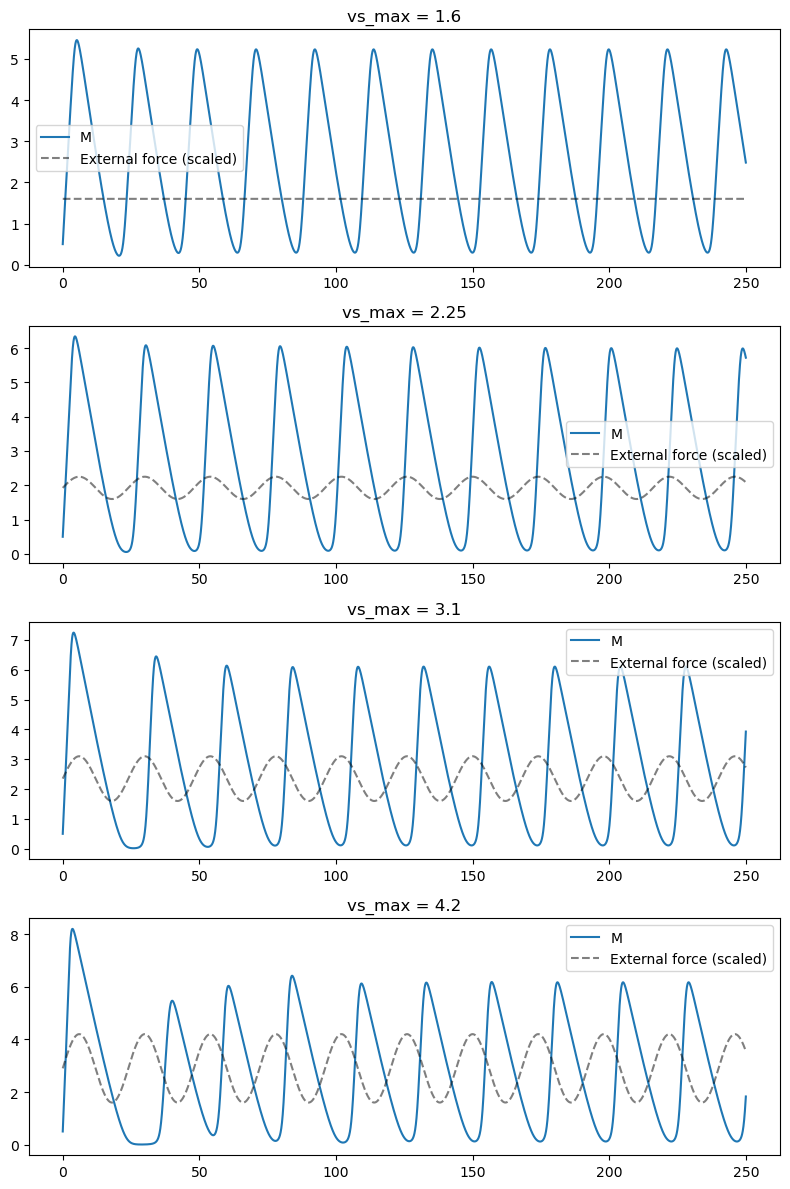

In [45]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# モデルパラメータ
n = 4
vm = 0.505
vd = 1.4
ks = 0.5
k1 = 0.5
k2 = 0.6
Km = 0.5
Kd = 0.13
KI = 1  # KIの値が与えられていないため、仮の値を使用
vs_min = 1.6  # vsの最小値

# 外力p(t)を定義 (振幅を調整するために修正)
def p(t, vs_min, vs_max):
    # -1から1の値をvs_minからvs_maxの範囲にスケール
    return vs_min + (vs_max - vs_min) * (np.sin(2 * np.pi * t / 24) + 1) / 2

# 微分方程式のシステム
def model(t, y, vs_max):
    M, FC, FN = y
    A = (vs_max - vs_min) / vs_min
    vs = vs_min * (1 + A * (np.sin(2 * np.pi * t / 24) + 1) / 2)  # p(t)を直接使う
    dMdt = vs * (KI**n / (KI**n + FN**n)) - vm * (M / (Km + M))
    dFCdt = ks * M - vd * (FC / (Kd + FC)) - k1 * FC + k2 * FN
    dFNdt = k1 * FC - k2 * FN
    return [dMdt, dFCdt, dFNdt]

# 時間設定
t_span = [0, 250]
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# 初期値
y0 = [0.5, 0.5, 0.5]  # 初期値も仮の値

# vs_maxの値に基づいてモデルを解く
vs_max_values = [1.6, 2.25, 3.1, 4.2]
results = {}

for vs_max in vs_max_values:
    sol = solve_ivp(model, t_span, y0, args=(vs_max,), t_eval=t_eval, max_step=0.01)
    results[vs_max] = sol.y

# プロットする
fig, axs = plt.subplots(len(vs_max_values), 1, figsize=(8, 12))

for i, vs_max in enumerate(vs_max_values):
    axs[i].plot(t_eval, results[vs_max][0], label='M')
    axs[i].plot(t_eval, p(t_eval, vs_min, vs_max), 'k--', label='External force (scaled)', alpha=0.5)  # 外力を点線で追加
    axs[i].set_title(f'vs_max = {vs_max}')
    axs[i].legend()

plt.tight_layout()
plt.show()
